In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import opendatasets as od

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV,KFold
from sklearn.metrics import classification_report


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
od.download('https://www.kaggle.com/datasets/blastchar/telco-customer-churn')

Skipping, found downloaded files in ".\telco-customer-churn" (use force=True to force download)


In [4]:
df = pd.read_csv('telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
print("The Dataset has %d rows and %d columns" %(df.shape[0],df.shape[1]))

The Dataset has 7043 rows and 21 columns


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
categorical_cols_list = list(df.select_dtypes(include='object').columns)
numerical_col_list = list(df.select_dtypes(exclude='object').columns)
print("The categorical columns of the dataframe are : ")
for i,col in enumerate(categorical_cols_list):
    print(i+1,col)

print("\nThe numerical columns of the dataframe are : ")
for i,col in enumerate(numerical_col_list):
    print(i+1,col)

The categorical columns of the dataframe are : 
1 customerID
2 gender
3 Partner
4 Dependents
5 PhoneService
6 MultipleLines
7 InternetService
8 OnlineSecurity
9 OnlineBackup
10 DeviceProtection
11 TechSupport
12 StreamingTV
13 StreamingMovies
14 Contract
15 PaperlessBilling
16 PaymentMethod
17 TotalCharges
18 Churn

The numerical columns of the dataframe are : 
1 SeniorCitizen
2 tenure
3 MonthlyCharges


In [8]:
categorical_df = df.select_dtypes(include='object')
print(categorical_df.nunique())

customerID          7043
gender                 2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
TotalCharges        6531
Churn                  2
dtype: int64


In [9]:
for col in categorical_cols_list[1:]:
    print("{}  -  {}".format(col,df[col].unique()))

gender  -  ['Female' 'Male']
Partner  -  ['Yes' 'No']
Dependents  -  ['No' 'Yes']
PhoneService  -  ['No' 'Yes']
MultipleLines  -  ['No phone service' 'No' 'Yes']
InternetService  -  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  -  ['No' 'Yes' 'No internet service']
OnlineBackup  -  ['Yes' 'No' 'No internet service']
DeviceProtection  -  ['No' 'Yes' 'No internet service']
TechSupport  -  ['No' 'Yes' 'No internet service']
StreamingTV  -  ['No' 'Yes' 'No internet service']
StreamingMovies  -  ['No' 'Yes' 'No internet service']
Contract  -  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  -  ['Yes' 'No']
PaymentMethod  -  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges  -  ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn  -  ['No' 'Yes']


In [10]:
# df[df['MultipleLines']=='No'][df['PhoneService']=='No']

In [11]:
err_col_list = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for col in err_col_list:
    df[col] = df[col].replace('No internet service','No')

### Preprocessing

In [12]:
df.drop('customerID',axis=1,inplace=True)

In [13]:

print("The number of columns with empty values in Total Charges are {}".format(len(df[df['TotalCharges']==" "])))
df = df[df['TotalCharges']!=" "]
df['TotalCharges'] = pd.to_numeric(df["TotalCharges"])
print("Dataset Updated: TotalCharges changed from str to float64")

The number of columns with empty values in Total Charges are 11
Dataset Updated: TotalCharges changed from str to float64


### Exploratory Data Analysis

In [14]:
from ExplDataAnalysis import plot_expl

Churn distribution by gender


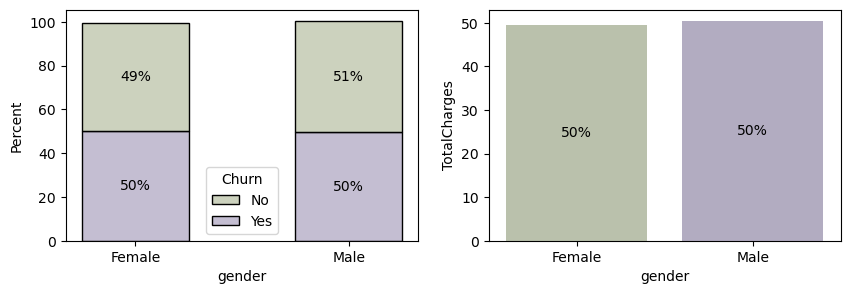

Churn distribution by InternetService


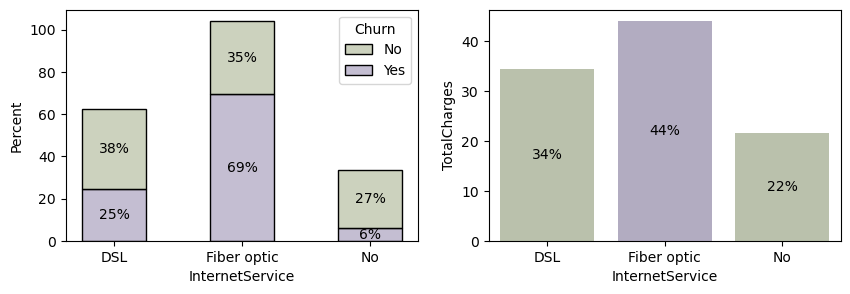

In [15]:
plot_expl(df,['gender','InternetService'])